In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Credit card Fraud detection with autoencoder

Outline:
- What is an autoencoder
- How to use an autoencoder for detecing anomaly
- Results

# Autoencoders

An autoencoder is a neural network that is trained to learn a latent representation of the training data distribution.

The autoencoder architecthure is compose of two parts:
- Encoder: it maps the input to a lower dimensional latent space (also called latent code)
- Decoder: it maps the latent space back to the input space

<img src="https://www.compthree.com/images/blog/ae/ae.png" width="600">

Because the latent space has a lower dimension than the input space the autoencoder must learn from the data what are the most important informations.

For example givan an image, the autoencoder first encoded the image into a lower dimensional latent representation, then decodes the latent representation back to an image. The goal of an autoencoder is to minimize the reconstruction loss between the orginal image and the reconstructed one.

**Self-supervised learning**

In order to train this type of neural network we do not need any label. The goal is to minimize the reconstruction loss (MSE, MAE in general).

$$ Loss(x) = norm(Decode(encode(x))  - x)$$

# How to use an autoencoder to detect anomaly?

We will use only non-fraudulent transaction in order to train the network, in this way the network will learn to reconstruct only the inputs coming from the same data distribution, while all other inputs will be reconstructed very poorly and the reconstruction loss will be very high. By exploting the reconstruction loss it is set a threshold to classify fraud transactions. 

In [3]:
data = pd.read_csv("creditcard.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
data["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [18]:
fraud = data.loc[data["Class"]==1, :].drop(["Time", "Class"], axis=1).values
normal = data.loc[data["Class"]==0, :].drop(["Time", "Class"], axis=1).values

In [19]:
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(normal, test_size=0.2, random_state=42)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=42)

xval will be used to detect overfitting during the training of the autoencoder. \
xtest and fraud will be used only at the end to compute the godness of the model.

In [20]:
# always normalize features before pass them to a neural network
#min_val = tf.reduce_min(x_train)
#max_val = tf.reduce_max(x_train)

#train_data = (x_train - min_val) / (max_val - min_val)
#val_data = (x_val - min_val) / (max_val - min_val)
#test_data = (x_test - min_val) / (max_val -min_val)
#fraud_data = (fraud - min_val) / (max_val - min_val)

train_data = tf.cast(x_train, tf.float32)
val_data = tf.cast(x_val, tf.float32)
test_data = tf.cast(x_test, tf.float32)
fraud_data = tf.cast(fraud, tf.float32)

In [24]:
train_data

<tf.Tensor: shape=(181961, 29), dtype=float32, numpy=
array([[-2.2668908e+00, -6.8612492e-01,  1.6568083e+00, ...,
         5.1230019e-01, -3.2226607e-01,  1.0000000e+00],
       [ 1.0820661e+00, -9.0259880e-01,  8.7823652e-02, ...,
        -9.4977871e-02,  2.0526100e-02,  1.5339999e+02],
       [ 9.7485363e-01, -3.9181858e-01,  6.6621763e-01, ...,
        -9.0319201e-02,  4.2596679e-02,  1.4500000e+02],
       ...,
       [-1.9735496e+00,  1.9404924e+00,  8.9424050e-01, ...,
        -4.5453110e-01, -1.8597512e+00,  1.3480000e+01],
       [-1.2974559e+00, -5.7378983e-01,  1.7491914e+00, ...,
        -5.1465638e-02,  7.5778879e-02,  3.6000000e+01],
       [-5.4176158e-01,  1.1879239e+00,  9.4354123e-01, ...,
         3.4413651e-01,  1.5116103e-01,  8.8999999e-01]], dtype=float32)>

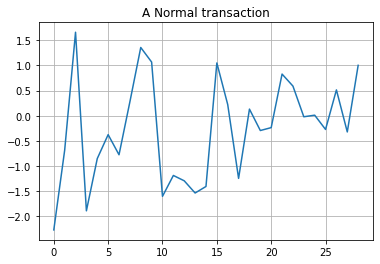

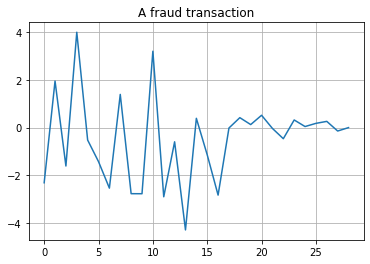

In [22]:
plt.grid()
plt.plot(np.arange(29), train_data[0])
plt.title("A Normal transaction")
plt.show()

plt.grid()
plt.plot(np.arange(29), fraud_data[0])
plt.title("A fraud transaction")
plt.show()

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses


class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(8, activation="relu")]) # the latent representation has only 8 dimensions

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(29, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [10]:
autoencoder.compile(optimizer='adam', loss='mae')

In [11]:
history = autoencoder.fit(train_data, train_data, 
          epochs=5, 
          batch_size=512,
          validation_data=(val_data, val_data),
          shuffle=True)

Epoch 1/5
356/356 [==============================] - 2s 2ms/step - loss: 0.1021 - val_loss: 0.0011
Epoch 2/5
356/356 [==============================] - 1s 2ms/step - loss: 4.7161e-04 - val_loss: 2.2441e-04
Epoch 3/5
356/356 [==============================] - 1s 2ms/step - loss: 2.0512e-04 - val_loss: 1.8902e-04
Epoch 4/5
356/356 [==============================] - 1s 2ms/step - loss: 1.8078e-04 - val_loss: 1.8409e-04
Epoch 5/5
356/356 [==============================] - 1s 2ms/step - loss: 1.8061e-04 - val_loss: 1.8423e-04


5687/5687 [==============================] - 4s 679us/step


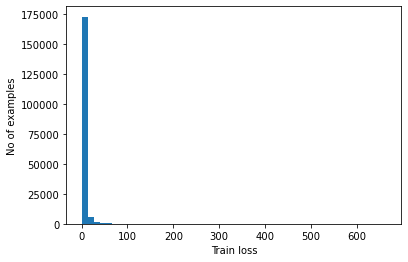

In [25]:
reconstructions = autoencoder.predict(train_data)
train_loss = tf.keras.losses.mae(reconstructions, train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [26]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  12.242238


# Results

- Accuracy
- Recall: the proportion of frauds that are correctly classified as frauds
- Precision: the proprotion of predicted frauds that are true frauds.

In [13]:
reconstructions = autoencoder.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions, test_data)

y_hat_test = test_loss >= threshold
y_true_test = np.zeros(y_hat_test.shape[0])
print(accuracy_score(y_true_test, y_hat_test))

0.9463974816664615


In [14]:
max(test_loss)

<tf.Tensor: shape=(), dtype=float32, numpy=0.04791759>

1.0


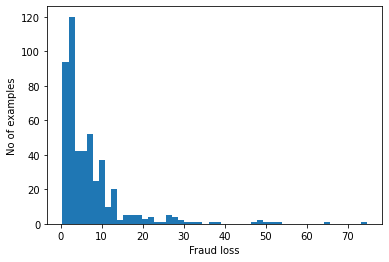

In [15]:
# normal transaction validation
reconstructions = autoencoder.predict(fraud)
fraud_loss = tf.keras.losses.mae(reconstructions, fraud)

y_hat_fraud = fraud_loss >= threshold
y_true_fraud = np.ones(fraud.shape[0])
print(accuracy_score(y_true_fraud, y_hat_fraud))

plt.hist(fraud_loss[None,:], bins=50)
plt.xlabel("Fraud loss")
plt.ylabel("No of examples")
plt.show()

In [16]:
min(fraud_loss)

<tf.Tensor: shape=(), dtype=float64, numpy=0.43139681607051217>

We have some transactions that are not fraudulent and we classify them as fraudulent, but all the fraudulent transactions are classified correctly. Also we do not have problem of False Negative: fraudulent transactions classified as normal transactions.